# Reinforcement Learning

<img src="imgs/RL_example.png" style="width: 900px">

- 玩家從中間開始走
- 每走一步扣 0.02 分
- 走到左端得 -1 分
- 走到右端得 1 分
- 走到左端或右端 該回合結束

In [13]:
import random

class Environment:
    def __init__(self):
        self.position = 3 # initial position
    
    def get_observation(self):
        return [ i for i in range(1, 6) ] # state space, 1 to 5
    
    def get_actions(self):
        return [ -1, 1 ] # left or right
    
    def is_done(self): # check if the game is over
        return self.position == 1 or self.position == 5 # if the agent reaches the left or right end
    
    def step(self, action): # take an action and return the next state and reward
        if self.is_done():
            raise Exception("Environment is already done.")
        self.position += action
        if self.position == 1:
            reward = -1
        elif self.position == 5:
            reward = 1
        else:
            reward = -0.02
        return self.position, reward

class Agent: # random agent
    def __init__(self):
        pass
    
    def action( self, env ): # take an action
        current_obs = env.get_observation() # get the current state
        return random.choice(env.get_actions()) # choose a random action

if __name__ == '__main__':
    env = Environment() # create an environment
    agent = Agent() # create an agent
    total_reward = 0 # total reward
    while not env.is_done(): # loop until the game is over
        action = agent.action(env) # take an action
        position, reward = env.step(action) # get the next state and reward
        total_reward += reward # accumulate the reward
        print( f"position: {env.position}, reward: {reward}, total_reward: {total_reward}")

position: 4, reward: -0.02, total_reward: -0.02
position: 3, reward: -0.02, total_reward: -0.04
position: 2, reward: -0.02, total_reward: -0.06
position: 3, reward: -0.02, total_reward: -0.08
position: 4, reward: -0.02, total_reward: -0.1
position: 5, reward: 1, total_reward: 0.9


## Stock Market Trading with RL
In this example, we use Reinforcement Learning to simulate and optimize trading decisions based on stock price movements. The agent interacts with the stock market environment to maximize cumulative profit over time.

1. Dataset: Stock Price Data
  - **Source**: Historical stock prices from Yahoo Finance or Alpha Vantage APIs.
  - **Content**: Data includes Open, High, Low, Close, Volume prices for a specific stock or index over a period of time.
  - **Format**: Typically stored in a CSV file.

In [34]:
import yfinance as yf
import pandas as pd

ticker = "AAPL" # Apple stock
data = yf.download(ticker, start="2010-01-01", end="2024-04-30") # download the data from Yahoo Finance
print( data.head() )
data.to_csv("data/AAPL.csv") # save the data to a CSV file

[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.447413  6.462175  6.398307  6.429939  493729600
2010-01-05  6.458558  6.495011  6.424514  6.465186  601904800
2010-01-06  6.355827  6.484167  6.349199  6.458559  552160000
2010-01-07  6.344075  6.386855  6.297981  6.379323  477131200
2010-01-08  6.386254  6.386857  6.298285  6.335642  447610800


The agent (trader) interacts with the market and takes actions to maximize cumulative reward (profit). Here’s how we define the RL components:

- Environment: Stock market simulation.
- State: A vector of features like current stock price, moving averages, and portfolio holdings.
- Actions:
  - 0: Hold the stock.
  - 1: Buy the stock.
  - 2: Sell the stock.
- Reward: The profit or loss from the action taken.

3. Framework: OpenAI Gym Custom Environment

We can use OpenAI Gym to create a custom environment for stock trading.

In [2]:
import gym # OpenAI Gym
import numpy as np
import pandas as pd
from gym import spaces # action and observation space

class StockTradingEnv(gym.Env): # custom environment
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()
        self.data = data # stock data
        self.current_step = 0 # current time step
        self.cash = 10000  # Starting cash balance
        self.shares = 0    # Number of shares held
        self.state = []    # State representation

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # {0: Hold, 1: Buy, 2: Sell}
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,)) # [current_price, cash_in_hand, shares_held]

    def reset(self): # reset the environment
        self.current_step = 0
        self.cash = 10000
        self.shares = 0
        self.state = self._get_state()
        return self.state

    def _get_state(self): # get the current state
        current_price = self.data['Close'].iloc[self.current_step] # current price of the stock
        return np.array([current_price, self.cash, self.shares]) # return the state as an array

    def step(self, action): # take an action
        done = False
        current_price = self.data['Close'].iloc[self.current_step] # current price of the stock

        if action == 1:  # Buy
            self.shares += 1
            self.cash -= current_price
        elif action == 2:  # Sell
            if self.shares > 0:
                self.shares -= 1
                self.cash += current_price

        reward = self.cash + self.shares * current_price - 10000  # Profit/loss
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        self.state = self._get_state()
        return self.state, reward, done, {}

# Load dataset
data = pd.read_csv("data/AAPL.csv")
env = StockTradingEnv(data)
env.data

,Date,Close,High,Low,Volume
2010-01-04,6.447413,6.462175,6.398307,6.429939,493729600
2010-01-05,6.458558,6.495011,6.424514,6.465186,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344075,6.386855,6.297981,6.379323,477131200
2010-01-08,6.386254,6.386857,6.298285,6.335642,447610800
...,...,...,...,...,...
2024-04-23,166.298264,166.447732,164.325406,164.753864,49537800
2024-04-24,168.410629,168.689619,165.610763,165.939560,48251800
2024-04-25,169.277496,169.994902,167.543764,168.918794,50558300
2024-04-26,168.689621,170.722259,168.570043,169.267532,44838400


### 4. Training the RL Agent
We use a Deep Q-Network (DQN) as the RL algorithm to train the trading agent. The DQN uses a neural network to approximate the Q-values for actions.

- Metric: Higher cumulative rewards indicate better learning and policy.
- Implementation: Modify the training loop to calculate cumulative rewards

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Define Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__() # call the constructor of the parent class
        self.fc = nn.Sequential( # fully connected layer
            nn.Linear(input_dim, 128), # input layer
            nn.ReLU(), # activation function
            nn.Linear(128, output_dim) # output layer
        )
    def forward(self, x): # forward pass of the network
        return self.fc(x) # return the output 

state_dim = 3 # dimension of the state
action_dim = 3 # dimension of the action
q_network = DQN(state_dim, action_dim)
optimizer = optim.Adam(q_network.parameters(), lr=0.001)

num_episodes = 100
gamma = 0.99  # Discount factor
rewards = []  # Store cumulative rewards
losses = []
for episode in range(num_episodes): 
    state = np.array(env.reset(), dtype=np.float32)
    done = False
    cumulative_reward = 0  # Initialize cumulative reward
    while not done:
        state_tensor = torch.FloatTensor(state)
        q_values = q_network(state_tensor)
        action = torch.argmax(q_values).item() if random.random() > 0.1 else random.randint(0, 2)

        next_state, reward, done, _ = env.step(action)
        cumulative_reward += reward  # Accumulate reward
        next_state = np.array(next_state, dtype=np.float32)

        next_state_tensor = torch.FloatTensor(next_state)

        # Compute target Q-value and update network (as in the code provided)
        target_q_value = reward + gamma * torch.max(q_network(next_state_tensor)).item()
        loss = (q_values[action] - target_q_value) ** 2
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
    rewards.append(cumulative_reward)
    print(f"Episode {episode+1}: Cumulative Reward: {cumulative_reward}")

Episode 1: Cumulative Reward: 1251234.1059236142
Episode 2: Cumulative Reward: 2091558.9749800994
Episode 3: Cumulative Reward: 844215.4344824395
Episode 4: Cumulative Reward: 600173.1679450865
Episode 5: Cumulative Reward: 825188.8643730297
Episode 6: Cumulative Reward: 1064587.654348344
Episode 7: Cumulative Reward: 1733227.569324456
Episode 8: Cumulative Reward: 1688147.9927519464
Episode 9: Cumulative Reward: 868118.7022851049
Episode 10: Cumulative Reward: 386153.25173261965
Episode 11: Cumulative Reward: 749077.295276532
Episode 12: Cumulative Reward: 602709.7114263719
Episode 13: Cumulative Reward: 801581.1770655948
Episode 14: Cumulative Reward: 690114.3527443327
Episode 15: Cumulative Reward: 818356.8533347999
Episode 16: Cumulative Reward: 1290132.403446356
Episode 17: Cumulative Reward: 914774.3531904804
Episode 18: Cumulative Reward: 962721.8891243875
Episode 19: Cumulative Reward: 723949.2587646507
Episode 20: Cumulative Reward: 511727.5506899633
Episode 21: Cumulative Rew

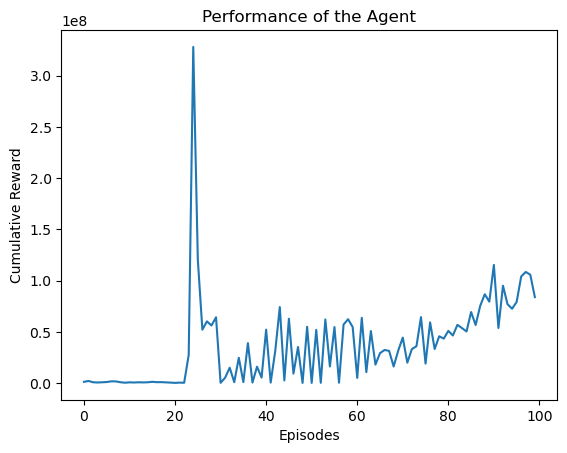

In [12]:
import matplotlib.pyplot as plt

# rewards = []  # Store cumulative rewards
# Append `cumulative_reward` to this list after each episode
plt.plot(range(len(rewards)), rewards)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Performance of the Agent")
plt.show()

In [13]:
success_criteria = 10  # Define a reward threshold for success
successes = 0
for episode in range(num_episodes):
    # Training code
    if cumulative_reward >= success_criteria:
        successes += 1

success_rate = successes / num_episodes
print(f"Success Rate: {success_rate * 100:.2f}%")


Success Rate: 100.00%


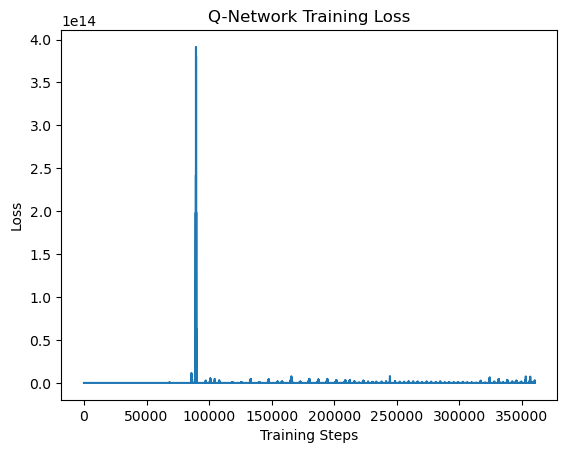

In [15]:

# Append `loss.item()` to the list during training
plt.plot(range(len(losses)), losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Q-Network Training Loss")
plt.show()